### Seasonal sea ice extent and nutrient availability in the Siberian Sea
* Do recent reductions in sea ice extent lead to decreased nutrient availabilty?
* Do models capture the extent and seasonality of sea ice extent? 

### Methods
* Observations: Daily sea ice concentration ranging from 2002 to 2019 obtained from AMSR2 and AMSR-E satellite products 
* Model data: Sea ice and nitrate concentration from CNRM and UKESM histrical runs ranging from 1850 to 2014


### Abstract

### Introduction

### Results 

In [2]:
# Load useful packages
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from datetime import datetime, timedelta
import numpy as np
import pyproj
from dask.diagnostics import ProgressBar
import matplotlib.dates as mdate
import intake
import cftime

In [3]:
# Import all satellite observations
sat = xr.open_mfdataset("SICdata/AMSR*.nc", combine='by_coords')

In [4]:
# Convert co-ordinates in satellite data from x and y to latitude and longitude
# We want the output coordinates in WGS 84 longitude and latitude
projOut = pyproj.Proj(init='epsg:4326')
# The input coordinates are in meters on a North Polar Stereographic grid 
projIn = pyproj.Proj(init='epsg:3411', preserve_units=True)
xx, yy = np.meshgrid( sat.x.values, sat.y.values)
lon,lat= pyproj.transform(projIn, projOut, xx, yy )
sat['lon'] = (('y','x'),lon)
sat['lat'] = (('y','x'),lat)

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/srv/conda/envs/notebook/lib/python3.9/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/tmp/ipykernel_431/1579399248.py:7: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon,lat= pyproj.tra

In [5]:
# Select area of interest: Siberian Sea
sat_SS = sat.where((sat.lon>= 100) & (sat.lon<= 160) & (sat.lat<= 80) & (sat.lat>= 70), drop = True) 

In [6]:
# Compute the sea ice extent (km^2) from sea ice concentration for the Siberian Sea
area = 6.25**2 # The satellite data grid cell sizes are the same (resolution of 6.25 km^2)
# We count the grid cells which have a sea ice concentration >15% and multiply by the area
with ProgressBar():
    iceExt = ((xr.where(sat_SS.z>15, 1.,0).sum(dim=['x','y']))*area ).compute()
iceExt=xr.where(iceExt>0,iceExt,np.NaN)

[########################################] | 100% Completed | 190.15 s


In [7]:
ys = np.unique(sat_SS.time.dt.year) #x axis = years
doy= np.arange(150,330) #y axis = day of years 
t2d = np.array([
    [np.datetime64(str(y)) + np.timedelta64(d, 'D') for d in doy ] 
        for y in ys])

In [8]:
ice2d = np.array([
        [ iceExt.sel(time=d) if d in iceExt.time else np.NaN for d in y ]
            for y in t2d ])

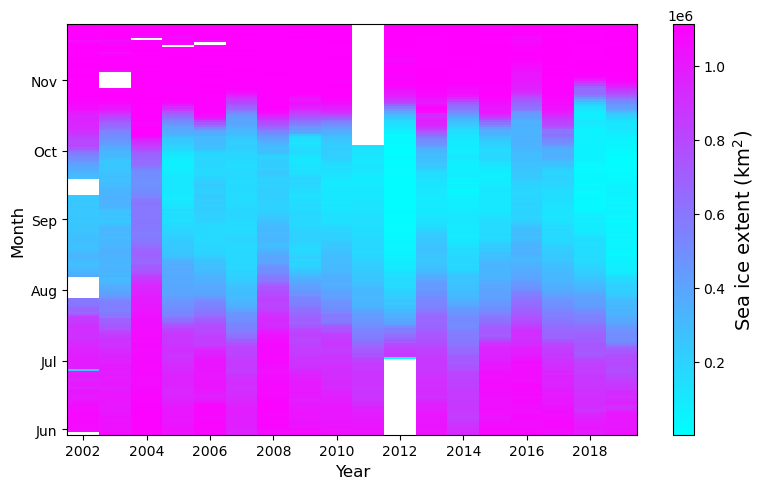

In [11]:
#Plot figure
fig, ax = plt.subplots(figsize = (8,5))
pl=ax.pcolormesh(ys, 
            [np.datetime64('2000') + np.timedelta64(d, 'D') for d in doy], 
               ice2d.T,
                cmap=plt.colormaps['cool'])
cbar = fig.colorbar(pl)
cbar.set_label(r'Sea ice extent (km$^{2}$)', size = 14)
fmt = mdate.DateFormatter('%b')
ax.yaxis.set_major_formatter(fmt)
ax.yaxis.set_major_locator(mdate.MonthLocator())
ax.set_ylabel('Month', size = 12)
ax.set_xlabel('Year', size = 12)
fig.tight_layout()
plt.savefig('Heatmap SS.png')

 Figure 1: A heat map indicating the 

### Discusssion and conclusions

### Acknowledgements

### References